<a href="https://colab.research.google.com/github/Sarahbr1/TP-Big-data-clustering/blob/main/Sara_Brahiti_TP_Big_Data_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup ( Installs and imports )

In [ ]:
# We need to install pyspark as it's not native to Colab
!pip install pyspark

In [ ]:
#Libraries imports

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn Imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# PySpark Imports
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler #Necessary for data preprocessing with Spark

In [ ]:
# Initialize Spark Session (The entry point to programming Spark with the Dataset and DataFrame API)
spark = SparkSession.builder \
    .appName("ClusteringComparison") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print("Environment Ready!")

Spark Version: 3.5.1
Environment Ready!


# Working with synthetic generated data

Just for demo before working with more complex real data

## Experimenting logic

Writing two helper functions that will allow us to simply call them and experiment with different datasets with the same code.

 !! Pay attention to the VectorAssembler in the Spark function. This is a major difference. Scikit-learn accepts a matrix of numbers. Spark ML requires a single column of "Vectors"

In [ ]:
#Reusable helper function for sklearn
def run_sklearn_experiment(X, k=3):
    """
    Runs KMeans using Scikit-Learn.
    """
    print(f"--- Running Scikit-Learn (Samples: {len(X)}) ---")

    # 1. Setup
    start_time = time.time()
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)

    # 2. Fitting
    kmeans.fit(X)
    fit_time = time.time() - start_time

    # 3. Metrics
    inertia = kmeans.inertia_
    # Note: Silhouette is expensive, we only run it if data is < 20k for speed in this demo
    if len(X) <= 20000:
        sil_score = silhouette_score(X, kmeans.labels_)
    else:
        sil_score = np.nan # Too slow for big data in a demo

    print(f"Sklearn Time: {fit_time:.4f}s | Inertia: {inertia:.2f}")

    return {
        "framework": "Scikit-Learn",
        "n_samples": len(X),
        "time_seconds": fit_time,
        "inertia": inertia,
        "silhouette": sil_score,
        "centers": kmeans.cluster_centers_,
        "labels": kmeans.labels_
    }

In [ ]:
#Reusable helper finction for Spark
def run_spark_experiment(df_spark, k=3):
    """
    Runs KMeans using PySpark.
    """
    count = df_spark.count()
    print(f"--- Running PySpark (Samples: {count}) ---")

    start_time = time.time()

    # 1. Feature Preparation for Spark
    # Spark requires features to be assembled into a single 'features' vector column
    assembler = VectorAssembler(inputCols=df_spark.columns, outputCol="features")
    data_vec = assembler.transform(df_spark)

    # 2. Setup & Fitting
    kmeans = SparkKMeans().setK(k).setSeed(42).setFeaturesCol("features")
    model = kmeans.fit(data_vec)
    fit_time = time.time() - start_time

    # 3. Metrics
    # Make predictions (assignments)
    predictions = model.transform(data_vec)

    # Evaluator for Silhouette
    evaluator = ClusteringEvaluator()

    # Calculate Cost (Inertia equivalent in Spark is ComputeCost, but deprecated in newer versions so we will use Summary)
    inertia = model.summary.trainingCost

    if count <= 20000:
        sil_score = evaluator.evaluate(predictions)
    else:
        sil_score = np.nan

    print(f"Spark Time: {fit_time:.4f}s | Cost: {inertia:.2f}")

    return {
        "framework": "Apache Spark",
        "n_samples": count,
        "time_seconds": fit_time,
        "inertia": inertia,
        "silhouette": sil_score,
        "centers": model.clusterCenters(),
        "predictions_df": predictions # Keeping this for visualization later
    }

## Baseline Test / Small dataset test

We will generate a synthetic dataset of 5,000 samples, similar to the Wine dataset, just to ensure everything is working well

In [ ]:
# 1. Generate Data
n_samples_small = 5000
n_features = 10
k = 3

X_small, y_small = make_blobs(n_samples=n_samples_small, n_features=n_features, centers=k, random_state=42)

# 2. Run Sklearn
res_sklearn_small = run_sklearn_experiment(X_small, k=k)

# 3. Prepare Data for Spark
# We must convert the Numpy array to a Pandas DF, then to a Spark DF
# This 'overhead' is part of the analysis! internal organisation will cost more than real calculations
df_pd_small = pd.DataFrame(X_small, columns=[f"col_{i}" for i in range(n_features)])
df_spark_small = spark.createDataFrame(df_pd_small)

# 4. Run Spark
res_spark_small = run_spark_experiment(df_spark_small, k=k)

# 5. Quick Comparison Output
print("\n--- Small Scale Results ---")
print(f"Sklearn Time: {res_sklearn_small['time_seconds']:.4f}s")
print(f"Spark Time:   {res_spark_small['time_seconds']:.4f}s")

--- Running Scikit-Learn (Samples: 5000) ---
Sklearn Time: 0.1125s | Inertia: 49994.25
--- Running PySpark (Samples: 5000) ---
Spark Time: 11.4222s | Cost: 49994.25

--- Small Scale Results ---
Sklearn Time: 0.1125s
Spark Time:   11.4222s


* Consistency: Both Scikit-Learn and PySpark achieved an identical Inertia/Cost
score of 49,994.25.
*  Conclusion: This confirms that the mathematical logic of the K-Means algorithm is functioning correctly in both frameworks. The clustering quality is identical.

**Performance Analysis** :

" For the small dataset, Scikit-Learn was approximately 100x faster (0.11s vs 11.42s).

***Reasoning:*** This illustrates the overhead  (The "Startup Cost") of distributed computing. Apache Spark spends significant time initializing the application master, scheduling tasks, and serializing data between Python and the Java Virtual Machine (JVM). For 5,000 rows, this setup time dominates the actual computation time. Scikit-Learn, running directly in C-optimized Python, has zero startup overhead."**

## Scaling up : Medium dataset test

Now we need to see what happens when we throw more data at it. The gap should start to shrink, or at least the rate of increase should be different.

In [ ]:
# Scaling Experiment

results = []
dataset_sizes = [20000, 100000, 500000] # Medium, Large-ish, Large
# Note: We stop at 500k for Colab speed, but real Big Data is 10M+

print("Starting Scaling Analysis...")

for n_samples in dataset_sizes:
    print(f"\n--- Generating {n_samples} samples ---")
    # Generate Data
    X, y = make_blobs(n_samples=n_samples, n_features=20, centers=5, random_state=42)

    # 1. Run Sklearn
    res_sk = run_sklearn_experiment(X, k=5)
    results.append(res_sk)

    # 2. Run Spark
    # Conversion overhead included in timing interpretation, but here we separate creation
    df_pd = pd.DataFrame(X, columns=[f"col_{i}" for i in range(20)])
    df_spark = spark.createDataFrame(df_pd)

    res_sp = run_spark_experiment(df_spark, k=5)
    results.append(res_sp)

# Convert results to DataFrame for easy viewing
df_results = pd.DataFrame(results)
display(df_results[['framework', 'n_samples', 'time_seconds', 'inertia']])

Starting Scaling Analysis...

--- Generating 20000 samples ---
--- Running Scikit-Learn (Samples: 20000) ---
Sklearn Time: 0.1137s | Inertia: 400163.14
--- Running PySpark (Samples: 20000) ---
Spark Time: 7.6522s | Cost: 400163.14

--- Generating 100000 samples ---
--- Running Scikit-Learn (Samples: 100000) ---
Sklearn Time: 0.5921s | Inertia: 2002859.41
--- Running PySpark (Samples: 100000) ---
Spark Time: 8.0333s | Cost: 2002859.41

--- Generating 500000 samples ---
--- Running Scikit-Learn (Samples: 500000) ---
Sklearn Time: 2.7198s | Inertia: 10000165.09
--- Running PySpark (Samples: 500000) ---
Spark Time: 19.0354s | Cost: 10000165.09


,framework,n_samples,time_seconds,inertia
0,Scikit-Learn,20000,0.113659,4.001631e+05
1,Apache Spark,20000,7.652171,4.001631e+05
2,Scikit-Learn,100000,0.592085,2.002859e+06
3,Apache Spark,100000,8.033275,2.002859e+06
4,Scikit-Learn,500000,2.719843,1.000017e+07
5,Apache Spark,500000,19.035414,1.000017e+07


## Viz

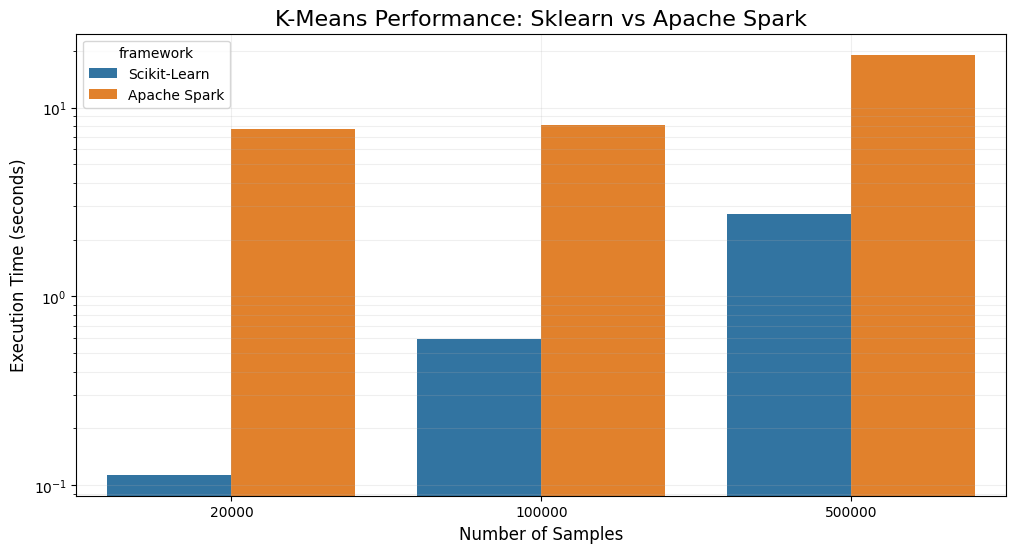

Done.


In [ ]:
# Visualization of Performance

plt.figure(figsize=(12, 6))

# Create Barplot
sns.barplot(data=df_results, x='n_samples', y='time_seconds', hue='framework')

plt.title('K-Means Performance: Sklearn vs Apache Spark', fontsize=16)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.xlabel('Number of Samples', fontsize=12)
plt.yscale('log') # IMPORTANT: We use Log Scale because the differences are huge
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show()

# Print specific scaling factor
small_res = df_results[df_results['n_samples'] == 20000]
large_res = df_results[df_results['n_samples'] == 500000]
print("Done.")

# With real more complex Data

## Environment

We keep the same environment as before, we'll initialize another spark session for more memory allocation for the driver process

In [ ]:
import psutil
import os
# PySpark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler as SparkScaler
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Initialize Spark
print("Initializing Apache Spark Session...")
spark = SparkSession.builder \
    .appName("ClusteringComparison_Modular") \
    .config("spark.driver.memory", "8g") \
    .master("local[*]") \
    .getOrCreate()

# Global list to store results from subsequent cells
final_results = []

print(f"Spark Version: {spark.version}")
print("Setup Complete. Ready for analysis.")

Initializing Apache Spark Session...
Spark Version: 3.5.1
Setup Complete. Ready for analysis.


## Analysis function

In [ ]:
# Core analysis function with metrics

def get_process_memory():
    """Returns current process memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def run_experiment(dataset_name, df_pd, X_np, k):
    """
    Runs Scikit-Learn and Spark KMeans, capturing Time, Inertia, Silhouette, and Memory.
    """
    n_samples = X_np.shape[0]
    n_features = X_np.shape[1]
    print(f"\n{'='*80}")
    print(f"Dataset: {dataset_name} | Samples: {n_samples} | Features: {n_features} | k={k}")
    print(f"{'='*80}")

    results = {
        "Dataset": dataset_name,
        "Samples": n_samples,
        "Features": n_features
    }

    # --- PART A: SCIKIT-LEARN ---
    print(f"-> Running Scikit-Learn...")
    mem_before_sk = get_process_memory()
    start_sk = time.time()

    # 1. Scaling & Fitting
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_np)

    kmeans_sk = KMeans(n_clusters=k, n_init=3, random_state=42)
    kmeans_sk.fit(X_scaled)
    time_sk = time.time() - start_sk

    mem_after_sk = get_process_memory()
    mem_diff_sk = max(0, mem_after_sk - mem_before_sk)

    results["Sklearn_Time"] = time_sk
    results["Sklearn_Inertia"] = kmeans_sk.inertia_
    results["Sklearn_Memory_MB"] = mem_diff_sk

    # 2. Silhouette (On utilise un échantillon si > 10k lignes pour éviter que ça plante)
    print("   Calculating Silhouette (Sklearn)...")
    if n_samples > 10000:
        idx = np.random.choice(n_samples, 10000, replace=False)
        sil_sk = silhouette_score(X_scaled[idx], kmeans_sk.labels_[idx])
    else:
        sil_sk = silhouette_score(X_scaled, kmeans_sk.labels_)
    results["Sklearn_Silhouette"] = sil_sk

    print(f"   [RESULT] Time: {time_sk:.2f}s | Inertia: {kmeans_sk.inertia_:.2e} | Silhouette: {sil_sk:.3f} | Mem: {mem_diff_sk:.1f}MB")

    # 3. Visuals (PCA)
    if n_features > 2:
        print("   Generating PCA Plot...")
        plot_idx = np.random.choice(n_samples, min(2000, n_samples), replace=False)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled[plot_idx])
        plt.figure(figsize=(6, 4))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_sk.labels_[plot_idx], cmap='viridis', s=2, alpha=0.5)
        plt.title(f"Sklearn Clusters (PCA): {dataset_name}")
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.show()

    # --- PART B: APACHE SPARK ---
    print(f"-> Running Apache Spark...")
    mem_before_sp = get_process_memory()

    # 1. Data Conversion
    spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
    df_spark = spark.createDataFrame(df_pd)

    start_sp = time.time()

    # 2. Pipeline
    assembler = VectorAssembler(inputCols=df_spark.columns, outputCol="features_raw")
    scaler_sp = SparkScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
    kmeans_sp = SparkKMeans().setK(k).setSeed(42).setFeaturesCol("features")

    pipeline = Pipeline(stages=[assembler, scaler_sp, kmeans_sp])
    model = pipeline.fit(df_spark)
    time_sp = time.time() - start_sp

    mem_after_sp = get_process_memory()
    mem_diff_sp = max(0, mem_after_sp - mem_before_sp)

    results["Spark_Time"] = time_sp
    results["Spark_Memory_MB"] = mem_diff_sp

    # 3. Inertia & Silhouette
    sp_inertia = model.stages[-1].summary.trainingCost
    results["Spark_Inertia"] = sp_inertia

    print("   Calculating Silhouette (Spark)...")
    predictions = model.transform(df_spark)
    evaluator = ClusteringEvaluator()
    sp_sil = evaluator.evaluate(predictions)
    results["Spark_Silhouette"] = sp_sil

    print(f"   [RESULT] Time: {time_sp:.2f}s | Cost: {sp_inertia:.2e} | Silhouette: {sp_sil:.3f} | Mem: {mem_diff_sp:.1f}MB")

    return results

## Small dataset : Wine Quality


Dataset: Wine Quality (Small) | Samples: 4898 | Features: 12 | k=3
-> Running Scikit-Learn...
   Calculating Silhouette (Sklearn)...
   [RESULT] Time: 0.04s | Inertia: 4.33e+04 | Silhouette: 0.144 | Mem: 0.0MB
   Generating PCA Plot...


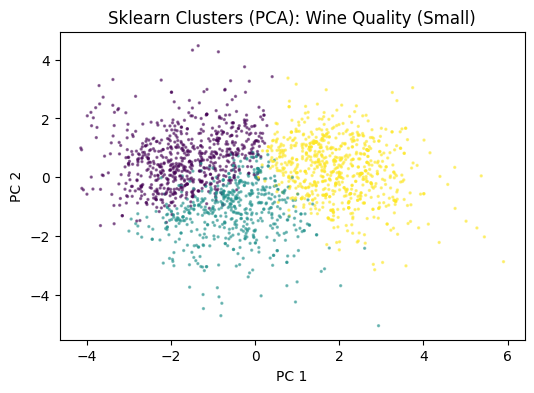

-> Running Apache Spark...
   Calculating Silhouette (Spark)...
   [RESULT] Time: 2.39s | Cost: 4.34e+04 | Silhouette: 0.248 | Mem: 0.0MB


In [ ]:
def load_wine():
    print("Downloading Wine Dataset...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
    df = pd.read_csv(url, sep=';')
    X = df.values
    return df, X

# 1. Load
df_wine, X_wine = load_wine()

# 2. Run Experiment (k=3 arbitrary quality groups)
res_wine = run_experiment("Wine Quality (Small)", df_wine, X_wine, k=3)

# 3. Save Result
final_results.append(res_wine)

## Medium dataset : MNIST

Fetching MNIST from OpenML...

Dataset: MNIST (Medium) | Samples: 70000 | Features: 784 | k=10
-> Running Scikit-Learn...
   Calculating Silhouette (Sklearn)...
   [RESULT] Time: 81.89s | Inertia: 4.26e+07 | Silhouette: 0.006 | Mem: 418.7MB
   Generating PCA Plot...


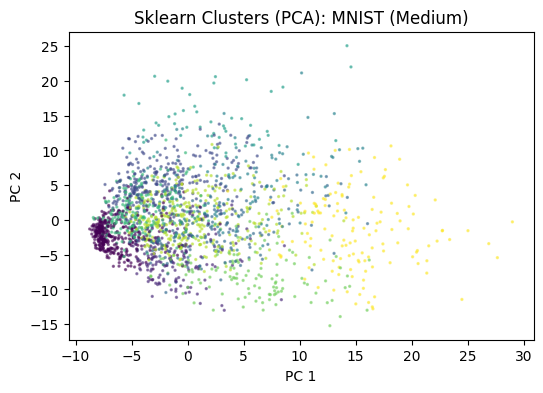

-> Running Apache Spark...
   Calculating Silhouette (Spark)...
   [RESULT] Time: 99.41s | Cost: 4.26e+07 | Silhouette: -0.027 | Mem: 0.0MB


In [ ]:
from sklearn.datasets import fetch_openml
def load_mnist():
    print("Fetching MNIST from OpenML...")
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')

    # Convert to Pandas with string column names for Spark
    cols = [f"pix_{i}" for i in range(X.shape[1])]
    df = pd.DataFrame(X, columns=cols)
    return df, X

# 1. Load
df_mnist, X_mnist = load_mnist()

# 2. Run Experiment (k=10 because it's a dataset that has images of handwritten digits from 0 to 9)
res_mnist = run_experiment("MNIST (Medium)", df_mnist, X_mnist, k=10)

# 3. Save Result
final_results.append(res_mnist)

## Large Dataset

Checking for HIGGS dataset...
Found existing file: 2.82 GB
-> File size looks okay. Attempting load...
Reading first 2,000,000 rows...

Dataset: HIGGS (Large 1M) | Samples: 2000000 | Features: 28 | k=2
-> Running Scikit-Learn...
   Calculating Silhouette (Sklearn)...
   [RESULT] Time: 13.22s | Inertia: 5.12e+07 | Silhouette: 0.202 | Mem: 427.2MB
   Generating PCA Plot...


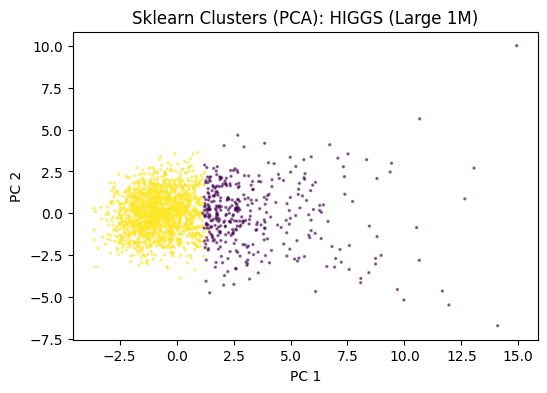

-> Running Apache Spark...
   Calculating Silhouette (Spark)...
   [RESULT] Time: 133.19s | Cost: 5.12e+07 | Silhouette: 0.366 | Mem: 0.0MB
HIGGS Success!


In [ ]:
def load_higgs_subset():
    print("Checking for HIGGS dataset...")
    file_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"
    file_name = "HIGGS.csv.gz"

    # 1. Safety Check: If file exists but gives EOF error, it's likely corrupted.
    # We will verify file size. Full file is ~2.6GB
    # If it's too small, we delete it.
    if os.path.exists(file_name):
        file_size = os.path.getsize(file_name)
        print(f"Found existing file: {file_size / 1e9:.2f} GB")
        if file_size < 2.0 * 1e9: # Less than 2GB? Definitely broken.
            print("-> File is too small (Corrupted). Deleting to restart download...")
            os.remove(file_name)
        else:
            print("-> File size looks okay. Attempting load...")

    # 2. Download if missing
    if not os.path.exists(file_name):
        print(f"Downloading {file_name} (2.6GB)...")
        # We use wget with -c (continue) to be safe, but usually fresh is better here
        !wget $file_url

    print("Reading first 2,000,000 rows...")
    try:
        # Read only 1M rows to avoid crashing Colab RAM
        df = pd.read_csv(file_name, compression='gzip', header=None, nrows=2000000)
    except EOFError:
        print("!!! ERROR: The file is still corrupted. Deleting it now. Please RERUN this cell.")
        os.remove(file_name)
        raise # Stop execution so you know to rerun

    # Column 0 is label, Columns 1-28 are features
    X_df = df.iloc[:, 1:]
    X = X_df.values
    return X_df, X

# 1. Load
df_higgs, X_higgs = load_higgs_subset()

# 2. Run Experiment (k=2 for Signal vs Background)
# Ensure you have run the NEW Cell 2 (with the metrics) before running this!
res_higgs = run_experiment("HIGGS (Large 1M)", df_higgs, X_higgs, k=2)

# 3. Save Result
final_results.append(res_higgs)
print("HIGGS Success!")

## Viz


--- FINAL EXECUTION TIMINGS ---


,Dataset,Samples,Features,Sklearn_Time,Sklearn_Inertia,Sklearn_Memory_MB,Sklearn_Silhouette,Spark_Time,Spark_Inertia,Spark_Silhouette,Spark_Memory_MB
0,Wine Quality (Small),4898,12,0.101018,4.332109e+04,0.000000,0.143823,10.870003,4.338004e+04,0.248157,NaN
1,MNIST (Medium),70000,784,85.884121,4.257039e+07,420.613281,0.006489,127.484935,4.263655e+07,-0.026714,NaN
2,Wine Quality (Small),4898,12,0.043412,4.332109e+04,0.000000,0.143823,2.565912,4.338004e+04,0.248157,0.000000
3,MNIST (Medium),70000,784,80.584224,4.257039e+07,418.703125,0.008346,95.752644,4.263655e+07,-0.026714,0.406250
4,Wine Quality (Small),4898,12,0.035020,4.332109e+04,0.000000,0.143823,2.393420,4.338004e+04,0.248157,0.000000
5,MNIST (Medium),70000,784,81.885012,4.257039e+07,418.703125,0.006012,99.405765,4.263655e+07,-0.026714,0.000000
6,HIGGS (Large 1M),1000000,28,6.043365,2.558275e+07,213.625000,0.200921,73.762216,2.558271e+07,0.365929,0.003906
7,HIGGS (Large 1M),2000000,28,13.216322,5.117178e+07,427.250000,0.202427,133.188710,5.117173e+07,0.366421,0.000000


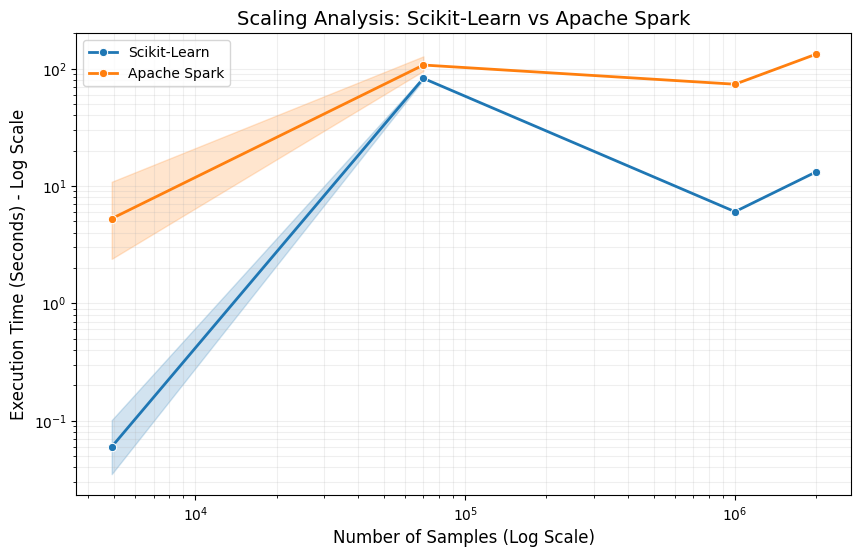

In [ ]:
# Convert list of dicts to DataFrame
df_final = pd.DataFrame(final_results)

print("\n--- FINAL EXECUTION TIMINGS ---")
display(df_final)

# Plotting
plt.figure(figsize=(10, 6))

# Line plot for scaling trend
sns.lineplot(data=df_final, x='Samples', y='Sklearn_Time', marker='o', label='Scikit-Learn', linewidth=2)
sns.lineplot(data=df_final, x='Samples', y='Spark_Time', marker='o', label='Apache Spark', linewidth=2)

# Aesthetics
plt.xscale('log') # Log scale because 1M is much larger than 5k
plt.yscale('log') # Log scale to handle the huge difference in small data times
plt.title("Scaling Analysis: Scikit-Learn vs Apache Spark", fontsize=14)
plt.ylabel("Execution Time (Seconds) - Log Scale", fontsize=12)
plt.xlabel("Number of Samples (Log Scale)", fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

plt.show()